In [ ]:
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from torch.utils.data import DataLoader, TensorDataset


# ============================================================
# AUXILIARY FUNCTIONS
# ============================================================

def set_seed(seed=1234):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convert series to supervised learning format.
    Source: machinelearningmastery.com
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    
    # Combine
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# ============================================================
# LSTM MODEL CLASS
# ============================================================

class LSTMNet(nn.Module):
    """LSTM model for volatility forecasting."""
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last timestep
        return self.fc(out)


# ============================================================
# MAIN FUNCTION
# ============================================================

def LSTM_model(neurons, lags, batch_size, epochs=1000, validation=False, early_stop=False, patience=100, verbose=True):
    """
    Train LSTM model with specified hyperparameters.
    
    Args:
        neurons: Number of hidden neurons
        lags: Number of lags per feature (timesteps)
        batch_size: Batch size for training
        epochs: Maximum number of epochs
        validation: If True, use validation set; if False, use test set
        early_stop: If True, use early stopping
        patience: Patience for early stopping
        verbose: If True, print training progress
    
    Returns:
        output object with learning history, performance measures, and predictions
    """
    set_seed(1234)
    
    # Load data
    data_path = os.path.join("..", "data", "processed", "sp500_ml_ready.csv")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
    # Select features: Target_Vol and Log_Return
    values = df[['Target_Vol', 'Log_Return']].values
    n_features = values.shape[1]
    
    # Normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    
    # Create supervised learning format
    reframed = series_to_supervised(scaled, n_in=lags, n_out=1)
    values_sup = reframed.values
    
    # Split the dataset
    train_row = int(round(0.60 * reframed.shape[0]))
    valid_row = int(round(0.80 * reframed.shape[0]))
    
    if validation:
        train = values_sup[:train_row, :]
        test = values_sup[train_row:valid_row, :]
    else:
        train = values_sup[:valid_row, :]
        test = values_sup[valid_row:, :]
    
    # Split into input and outputs
    n_input = lags * n_features
    train_X, train_y = train[:, :n_input], train[:, -n_features]  # -n_features gets Target_Vol(t)
    test_X, test_y = test[:, :n_input], test[:, -n_features]
    
    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape(train_X.shape[0], lags, n_features)
    test_X = test_X.reshape(test_X.shape[0], lags, n_features)
    
    # Convert to PyTorch tensors
    train_X_t = torch.tensor(train_X, dtype=torch.float32)
    train_y_t = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_X_t = torch.tensor(test_X, dtype=torch.float32)
    test_y_t = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)
    
    # Create DataLoaders
    train_dataset = TensorDataset(train_X_t, train_y_t)
    test_dataset = TensorDataset(test_X_t, test_y_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Design network
    model = LSTMNet(input_size=n_features, hidden_size=neurons, num_layers=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    best_loss = float('inf')
    best_weights = None
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)
        
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        
        # Early stopping
        if early_stop:
            if val_loss < best_loss:
                best_loss = val_loss
                best_weights = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    break
    
    if early_stop and best_weights:
        model.load_state_dict(best_weights)
    
    # Define function to return predictions from LSTM
    def LSTM_predict(model, X, y, scaler, n_features, lags):
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            yhat = model(X_t).numpy()
        
        # Reshape for inverse transform
        X_flat = X.reshape(X.shape[0], n_features * lags)
        
        # Invert scaling for forecast
        inv_yhat = np.concatenate((yhat, X_flat[:, -1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:, 0]
        
        # Invert scaling for actual
        y = y.reshape((len(y), 1))
        inv_y = np.concatenate((y, X_flat[:, -1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:, 0]
        
        return pd.DataFrame({'RV': inv_y, 'LSTM': inv_yhat})
    
    # Predicted values in-sample and out-of-sample
    LSTM_train = LSTM_predict(model, train_X, train_y, scaler, n_features, lags)
    LSTM_test = LSTM_predict(model, test_X, test_y, scaler, n_features, lags)
    
    # Compute performance measures
    rmse_in = np.sqrt(mse(LSTM_train['RV'], LSTM_train['LSTM']))
    rmse_out = np.sqrt(mse(LSTM_test['RV'], LSTM_test['LSTM']))
    mae_in = mae(LSTM_train['RV'], LSTM_train['LSTM'])
    mae_out = mae(LSTM_test['RV'], LSTM_test['LSTM'])
    
    perf_data = {
        'RMSE_in': rmse_in,
        'RMSE_out': rmse_out,
        'MAE_in': mae_in,
        'MAE_out': mae_out
    }
    perf_meas = pd.DataFrame(perf_data, index=['LSTM'])
    
    # Combine predictions
    yhat = np.concatenate([
        np.full((lags,), np.nan),
        LSTM_train['LSTM'].values,
        LSTM_test['LSTM'].values
    ], axis=0)
    
    # Create output object
    class Output:
        def __init__(self):
            self.learning = {'train_loss': train_losses, 'val_loss': val_losses}
            self.perf_meas = perf_meas
            self.yhat = yhat
            self.model = model
            self.scaler = scaler
    
    return Output()


# ============================================================
# HYPERPARAMETER OPTIMIZATION
# ============================================================

def find_optimal_neurons_lags():
    """Find the optimal number of neurons and lags."""
    print("="*60)
    print("FINDING OPTIMAL NEURONS AND LAGS")
    print("="*60)
    
    n_lags = []
    n_neurons = []
    rmse = []
    
    for lags in range(1, 7):  
        for neuron in range(2, 22, 2):  
            n_lags.append(lags)
            n_neurons.append(neuron)
            
            output = LSTM_model(
                neuron, lags, batch_size=32,
                epochs=2000, validation=True, early_stop=True, patience=100, verbose=False
            )
            rmse_out = output.perf_meas['RMSE_out'][0]
            rmse.append(rmse_out)
            print(f"Lags={lags}, Neurons={neuron}, RMSE_out={rmse_out:.6f}")
    
    # Create DataFrame
    hyp_1 = pd.DataFrame({'lags': n_lags, 'neurons': n_neurons, 'rmse': rmse})
    
    # Save to CSV
    os.makedirs("models", exist_ok=True)
    hyp_1.to_csv(os.path.join("..", "models", "table_neurons-lags.csv"), index=False)
    print("\nSaved: models/table_neurons-lags.csv")
    
    # Create pivot table for display
    pivot_table = hyp_1.pivot(index='neurons', columns='lags', values='rmse')
    print("\nRMSE for different combinations of hidden neurons and lags:")
    print(pivot_table.round(4).to_string())
    
    # Find best combination
    best_idx = hyp_1['rmse'].idxmin()
    best_lags = hyp_1.loc[best_idx, 'lags']
    best_neurons = hyp_1.loc[best_idx, 'neurons']
    best_rmse = hyp_1.loc[best_idx, 'rmse']
    print(f"\nBest: Lags={best_lags}, Neurons={best_neurons}, RMSE={best_rmse:.6f}")
    
    return hyp_1, int(best_lags), int(best_neurons)


def find_best_batch_size(lags, neurons):
    """Find the best batch size."""
    print("\n" + "="*60)
    print("FINDING BEST BATCH SIZE")
    print("="*60)
    
    # Load data to get n for batch gradient descent
    data_path = os.path.join("..", "data", "processed", "sp500_ml_ready.csv")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    n = int(round(0.60 * (df.shape[0] - lags)))
    
    # Batch sizes to test
    bs_list = [1]  # Stochastic gradient descent
    bs_list += [int(round(2**i)) for i in np.arange(5, 10, 1)]  # 32, 64, 128, 256, 512
    bs_list.append(n)  # Batch gradient descent
    
    batchsize = []
    rmse = []
    
    for bs in bs_list:
        batchsize.append(bs)
        output = LSTM_model(
            neurons, lags, batch_size=bs,
            epochs=2000, validation=True, early_stop=True, patience=100, verbose=False
        )
        rmse_out = output.perf_meas['RMSE_out'][0]
        rmse.append(rmse_out)
        print(f"Batch size={bs}, RMSE_out={rmse_out:.6f}")
    
    # Create DataFrame
    hyp_2 = pd.DataFrame({'batch_size': batchsize, 'rmse': rmse})
    hyp_2.to_csv(os.path.join("..", "models", "table_batch_sizes.csv"), index=False)
    print("\nSaved: models/table_batch_sizes.csv")
    
    # Plot RMSE vs batch size
    os.makedirs(os.path.join("..", "plots"), exist_ok=True)
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(rmse)), rmse, 'k-', marker='o', markersize=4)
    
    ax.grid(True, alpha=0.3)
    ax.set_xticks(np.arange(0, len(batchsize), 1))
    ax.set_xticklabels([str(i) for i in batchsize])
    ax.set_xlabel('Batch size')
    ax.set_ylabel('RMSE')
    
    # Set y-axis limits with small margin
    y_min = min(rmse) - 0.0005
    y_max = max(rmse) + 0.0005
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    fig.savefig(os.path.join("..", "plots", "best_batch_size.png"), dpi=150)
    plt.close()
    print("Saved: plots/best_batch_size.png")
    
    # Find best batch size
    best_idx = hyp_2['rmse'].idxmin()
    best_bs = hyp_2.loc[best_idx, 'batch_size']
    print(f"\nBest batch size: {best_bs}")
    
    return hyp_2, int(best_bs)


def find_best_epoch(neurons, lags, batch_size):
    """Find the best epoch by plotting train vs validation error."""
    print("\n" + "="*60)
    print("FINDING BEST EPOCH")
    print("="*60)
    
    # Train without early stopping to see full learning curve
    output = LSTM_model(
        neurons, lags, batch_size=batch_size,
        epochs=2000, validation=True, early_stop=False, verbose=True
    )
    
    loss_train = output.learning['train_loss']
    loss_valid = output.learning['val_loss']
    
    # Convert to RMSE
    rmse_train = [np.sqrt(l) for l in loss_train]
    rmse_valid = [np.sqrt(l) for l in loss_valid]
    
    # Plot train error vs validation error
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(rmse_train, 'k-', label='training')
    ax.plot(rmse_valid, 'k--', label='validation')
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('RMSE')
    ax.set_title('Training vs Validation RMSE')
    
    plt.tight_layout()
    fig.savefig(os.path.join("..", "plots", "best_epoch.png"), dpi=150)
    plt.close()
    print("Saved: plots/best_epoch.png")
    
    # Find best epoch (minimum validation loss)
    best_epoch = np.argmin(loss_valid) + 1
    print(f"\nBest epoch: {best_epoch}")
    
    return best_epoch, output


def plot_dataset_split(lags):
    """Plot the dataset split."""
    print("\n" + "="*60)
    print("PLOTTING DATASET SPLIT")
    print("="*60)
    
    data_path = os.path.join("..", "data", "processed", "sp500_ml_ready.csv")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
    # Calculate split indices
    n_samples = df.shape[0] - lags
    train_row = int(round(0.60 * n_samples)) + lags
    valid_row = int(round(0.80 * n_samples)) + lags
    
    # Create figure
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Plot each split
    ax.plot(df.index[lags:train_row], df['Target_Vol'].iloc[lags:train_row], 
            color='#1f77b4', label='training', linewidth=0.8)
    ax.plot(df.index[train_row:valid_row], df['Target_Vol'].iloc[train_row:valid_row], 
            color='#ff7f0e', label='validation', linewidth=0.8)
    ax.plot(df.index[valid_row:], df['Target_Vol'].iloc[valid_row:], 
            color='#2ca02c', label='test', linewidth=0.8)
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    ax.set_ylabel('Realized Volatility')
    ax.set_xlabel('')
    
    # Set date limits
    datemin = df.index[lags]
    datemax = df.index[-1]
    ax.set_xlim(datemin, datemax)
    
    plt.tight_layout()
    fig.savefig(os.path.join("..", "plots", "dataset_split.png"), dpi=150)
    plt.close()
    print("Saved: plots/dataset_split.png")


def out_of_sample_forecasting(neurons, lags, batch_size, epochs):
    """Perform out-of-sample forecasting and plot results."""
    print("\n" + "="*60)
    print("OUT-OF-SAMPLE FORECASTING")
    print("="*60)
    
    # Train final model on train+validation, test on test set
    best_LSTM = LSTM_model(
        neurons=neurons, lags=lags, batch_size=batch_size,
        epochs=epochs, validation=False, early_stop=False, verbose=True
    )
    
    # Load data for plotting
    data_path = os.path.join("..", "data", "processed", "sp500_ml_ready.csv")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
    # Add predictions to dataframe
    df['LSTM'] = np.nan
    df['LSTM'].iloc[:len(best_LSTM.yhat)] = best_LSTM.yhat
    
    # Calculate split indices
    n_samples = df.shape[0] - lags
    valid_row = int(round(0.80 * n_samples)) + lags
    
    # Create figure
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Plot actual RV
    ax.plot(df.index[lags:], df['Target_Vol'].iloc[lags:], 
            color='black', alpha=0.5, label='RV', linewidth=0.8)
    
    # Plot fitted (training + validation)
    ax.plot(df.index[lags:valid_row], df['LSTM'].iloc[lags:valid_row], 
            color='blue', alpha=0.7, label='fitted', linewidth=0.8)
    
    # Plot predicted (test)
    ax.plot(df.index[valid_row:], df['LSTM'].iloc[valid_row:], 
            color='gold', alpha=0.9, label='predicted', linewidth=1.0)
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    ax.set_ylabel('Realized Volatility')
    
    datemin = df.index[lags]
    datemax = df.index[-1]
    ax.set_xlim(datemin, datemax)
    
    plt.tight_layout()
    fig.savefig(os.path.join("..", "plots", "LSTM_train-test.png"), dpi=150)
    plt.close()
    print("Saved: plots/LSTM_train-test.png")
    
    return best_LSTM


def show_performance_measures(output):
    """Display performance measures."""
    print("\n" + "="*60)
    print("PERFORMANCE MEASURES")
    print("="*60)
    print(output.perf_meas.to_string())
    
    return output.perf_meas


# ============================================================
# MAIN EXECUTION
# ============================================================

def run_full_analysis():
    """Run the complete LSTM analysis pipeline."""
    
    # 1. Plot dataset split
    lags_init = 2  # Initial lags for plotting
    plot_dataset_split(lags_init)
    
    # 2. Find optimal neurons and lags
    hyp_1, best_lags, best_neurons = find_optimal_neurons_lags()
    
    # 3. Find best batch size
    hyp_2, best_batch_size = find_best_batch_size(best_lags, best_neurons)
    
    # 4. Find best epoch
    best_epoch, _ = find_best_epoch(best_neurons, best_lags, best_batch_size)
    
    # 5. Out-of-sample forecasting
    best_LSTM = out_of_sample_forecasting(
        neurons=best_neurons,
        lags=best_lags,
        batch_size=best_batch_size,
        epochs=best_epoch
    )
    
    # 6. Show performance measures
    pm = show_performance_measures(best_LSTM)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
    print(f"Best hyperparameters:")
    print(f"  - Neurons: {best_neurons}")
    print(f"  - Lags: {best_lags}")
    print(f"  - Batch size: {best_batch_size}")
    print(f"  - Epochs: {best_epoch}")
    
    return best_LSTM, pm


if __name__ == "__main__":
    best_LSTM, performance = run_full_analysis()


PLOTTING DATASET SPLIT
Saved: plots/dataset_split.png
FINDING OPTIMAL NEURONS AND LAGS


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=2, RMSE_out=0.000212


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=4, RMSE_out=0.000215


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=6, RMSE_out=0.000200


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=8, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=10, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=12, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=14, RMSE_out=0.000168


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=16, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=18, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=1, Neurons=20, RMSE_out=0.000170


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=2, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=4, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=6, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=8, RMSE_out=0.000165


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=10, RMSE_out=0.000165


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=12, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=14, RMSE_out=0.000167


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=16, RMSE_out=0.000167


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=18, RMSE_out=0.000166


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=2, Neurons=20, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=2, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=4, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=6, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=8, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=10, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=12, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=14, RMSE_out=0.000161


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=16, RMSE_out=0.000168


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=18, RMSE_out=0.000165


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=3, Neurons=20, RMSE_out=0.000161


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=2, RMSE_out=0.000159


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=4, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=6, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=8, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=10, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=12, RMSE_out=0.000157


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=14, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=16, RMSE_out=0.000169


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=18, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=4, Neurons=20, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=2, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=4, RMSE_out=0.000165


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=6, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=8, RMSE_out=0.000164


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=10, RMSE_out=0.000159


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=12, RMSE_out=0.000157


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=14, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=16, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=18, RMSE_out=0.000162


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=5, Neurons=20, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=2, RMSE_out=0.000159


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=4, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=6, RMSE_out=0.000161


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=8, RMSE_out=0.000161


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=10, RMSE_out=0.000158


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=12, RMSE_out=0.000158


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=14, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=16, RMSE_out=0.000163


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=18, RMSE_out=0.000160


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Lags=6, Neurons=20, RMSE_out=0.000158

Saved: models/table_neurons-lags.csv

RMSE for different combinations of hidden neurons and lags:
lags          1       2       3       4       5       6
neurons                                                
2        0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
4        0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
6        0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
8        0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
10       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
12       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
14       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
16       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
18       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
20       0.0002  0.0002  0.0002  0.0002  0.0002  0.0002

Best: Lags=5, Neurons=12, RMSE=0.000157

FINDING BEST BATCH SIZE


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=1, RMSE_out=0.000227


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=32, RMSE_out=0.000157


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=64, RMSE_out=0.000161


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=128, RMSE_out=0.000169


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=256, RMSE_out=0.000165


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=512, RMSE_out=0.000159


/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rmse_out = output.perf_meas['RMSE_out'][0]


Batch size=5423, RMSE_out=0.000158

Saved: models/table_batch_sizes.csv
Saved: plots/best_batch_size.png

Best batch size: 32

FINDING BEST EPOCH
Epoch 100 | Train Loss: 0.002105 | Val Loss: 0.000783
Epoch 200 | Train Loss: 0.001656 | Val Loss: 0.000645
Epoch 300 | Train Loss: 0.001539 | Val Loss: 0.000697
Epoch 400 | Train Loss: 0.001322 | Val Loss: 0.000815
Epoch 500 | Train Loss: 0.001137 | Val Loss: 0.001133
Epoch 600 | Train Loss: 0.001073 | Val Loss: 0.001464
Epoch 700 | Train Loss: 0.001024 | Val Loss: 0.001558
Epoch 800 | Train Loss: 0.000987 | Val Loss: 0.001543
Epoch 900 | Train Loss: 0.000958 | Val Loss: 0.001654
Epoch 1000 | Train Loss: 0.000938 | Val Loss: 0.001869
Epoch 1100 | Train Loss: 0.000904 | Val Loss: 0.001682
Epoch 1200 | Train Loss: 0.000912 | Val Loss: 0.001956
Epoch 1300 | Train Loss: 0.000864 | Val Loss: 0.002117
Epoch 1400 | Train Loss: 0.000844 | Val Loss: 0.002362
Epoch 1500 | Train Loss: 0.000833 | Val Loss: 0.002243
Epoch 1600 | Train Loss: 0.000808 | Va

/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykernel_55557/1649894066.py:497: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['LSTM'].iloc[:len(best_LSTM.yhat)] = best_LSTM.yhat
/var/folders/j4/_ftb15bs147f0ljzkwys5h680000gn/T/ipykern

Starting training for MLP...
Epoch 10 | Train Loss: 0.6020 | Val Loss: 0.1316
Epoch 20 | Train Loss: 0.5218 | Val Loss: 0.1334
Early stopping triggered.
Starting training for LSTMModel...
Epoch 10 | Train Loss: 0.6310 | Val Loss: 0.1331
Epoch 20 | Train Loss: 0.4820 | Val Loss: 0.1325
Epoch 30 | Train Loss: 0.4286 | Val Loss: 0.1383
Early stopping triggered.

--- Final Results (Validation Set - Unscaled) ---
MLP: MSE=0.00000002, R2=0.204731
LSTM: MSE=0.00000002, R2=0.183351
New comparison plot saved.


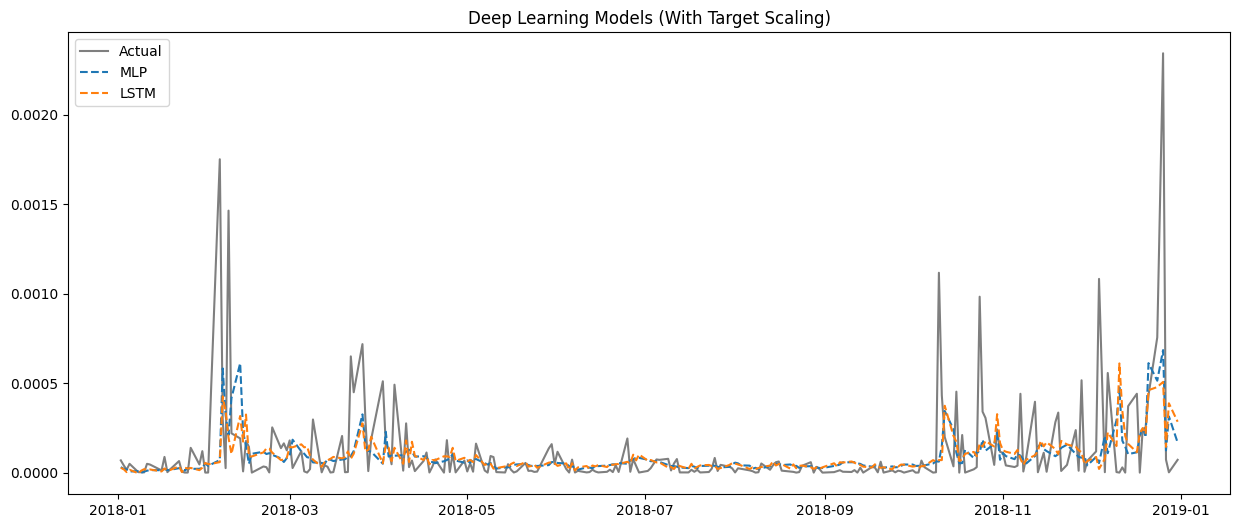

In [5]:
import copy
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
class TimeSeriesDataset(Dataset):
    """Wrap feature and target arrays into a PyTorch Dataset."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP(nn.Module):
    """A simple multilayer perceptron for tabular regression."""
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class LSTMModel(nn.Module):
    """An LSTM-based regressor for tabular time-series features."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    """Train a model with early stopping and return losses."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    best_weights = None
    patience_counter = 0
    
    train_losses = []
    val_losses = []

    print(f"Starting training for {model.__class__.__name__}...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                running_val_loss += loss.item() * X_val.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    if best_weights:
        model.load_state_dict(best_weights)
    return model, train_losses, val_losses

def run_deep_learning():
    """Train deep learning models on engineered volatility features."""
    data_path = os.path.join("data", "processed", "sp500_ml_ready.csv")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)

    drop_cols = ['Target_Vol', 'Log_Return']
    feature_cols = [c for c in df.columns if c not in drop_cols and ('Lag' in c or 'Roll' in c)]

    X = df[feature_cols].values
    y = df['Target_Vol'].values.reshape(-1, 1)

    train_mask = df.index < '2015-01-01'
    val_mask = (df.index >= '2015-01-01') & (df.index < '2020-01-01')

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)

    batch_size = 64
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val_scaled)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X_train.shape[1]
    results = {}

    mlp = MLP(input_dim)
    mlp, _, _ = train_model(mlp, train_loader, val_loader)
    results['MLP'] = mlp

    lstm = LSTMModel(input_dim)
    lstm, _, _ = train_model(lstm, train_loader, val_loader)
    results['LSTM'] = lstm

    print("\n--- Final Results (Validation Set - Unscaled) ---")

    def eval_and_plot(model, name):
        model.eval()
        with torch.no_grad():
            preds_scaled = model(torch.tensor(X_val_scaled, dtype=torch.float32)).numpy()
            preds_real = scaler_y.inverse_transform(preds_scaled)

            mse = mean_squared_error(y_val, preds_real)
            r2 = r2_score(y_val, preds_real)
            print(f"{name}: MSE={mse:.8f}, R2={r2:.6f}")
            return preds_real

    plt.figure(figsize=(15, 6))
    val_indices = df.index[val_mask]
    plot_mask = (val_indices >= '2018-01-01') & (val_indices <= '2018-12-31')

    plt.plot(val_indices[plot_mask], y_val[plot_mask], label='Actual', color='black', alpha=0.5)

    preds_mlp = eval_and_plot(results['MLP'], "MLP")
    plt.plot(val_indices[plot_mask], preds_mlp[plot_mask], label='MLP', linestyle='--')

    preds_lstm = eval_and_plot(results['LSTM'], "LSTM")
    plt.plot(val_indices[plot_mask], preds_lstm[plot_mask], label='LSTM', linestyle='--')

    plt.title('Deep Learning Models (With Target Scaling)')
    plt.legend()
    os.makedirs("plots", exist_ok=True)
    plt.savefig('plots/model_comparison_dl_scaled.png')
    print("New comparison plot saved.")

if __name__ == "__main__":
    run_deep_learning()

In [6]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

--- Starting Rolling Backtest (Test Set: 2020-2025) ---
Test Set Range: 2020-01-02 00:00:00 to 2025-12-30 00:00:00
Test Samples: 1507
Generating predictions...

--- Test Set Results ---
MSE: 0.00000039
MAE: 0.00018491
R²:  0.236346
Saved final backtest plot to plots/final_backtest.png


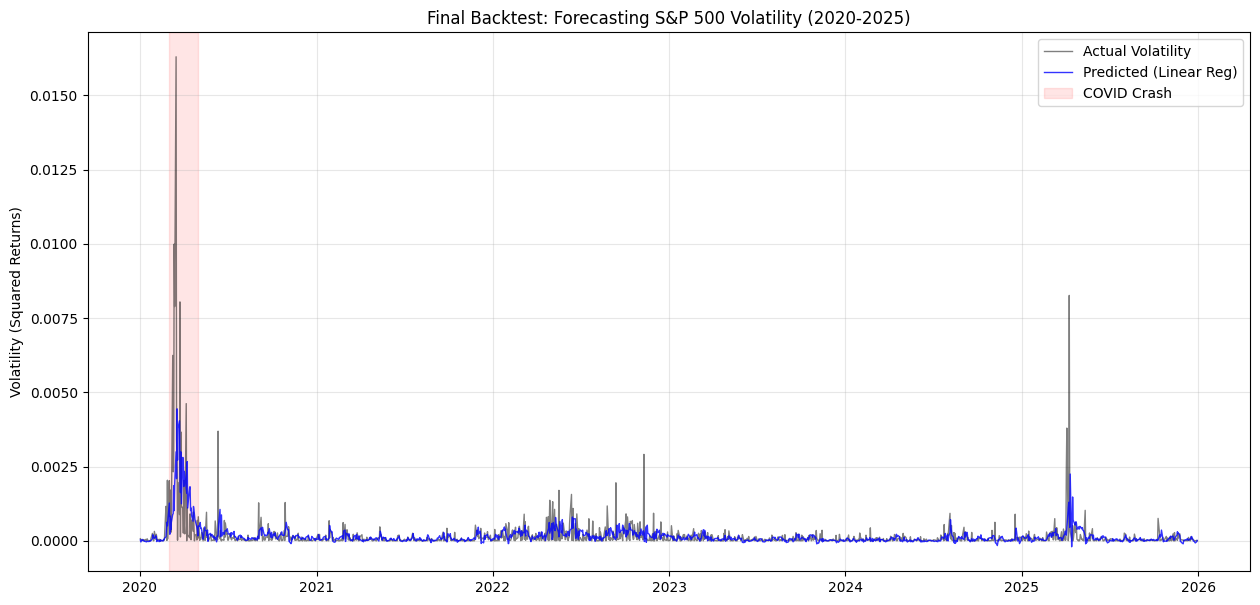

In [7]:
def run_backtest():
    """Run a rolling-style backtest on the 2020-2025 test window."""
    print("--- Starting Rolling Backtest (Test Set: 2020-2025) ---")

    data_path = os.path.join("data", "processed", "sp500_ml_ready.csv")
    model_path = os.path.join("models", "Linear_Regression.pkl")

    if not os.path.exists(data_path) or not os.path.exists(model_path):
        print("Error: Missing data or model file.")
        return

    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    model = joblib.load(model_path)

    test_mask = df.index >= '2020-01-01'
    df_test = df[test_mask].copy()

    drop_cols = ['Target_Vol', 'Log_Return']
    feature_cols = [
        c
        for c in df.columns
        if c not in drop_cols and ('Lag' in c or 'Roll' in c)
    ]

    X_test = df_test[feature_cols]
    y_test = df_test['Target_Vol']

    print(f"Test Set Range: {df_test.index.min()} to {df_test.index.max()}")
    print(f"Test Samples: {len(df_test)}")

    print("Generating predictions...")
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print("\n--- Test Set Results ---")
    print(f"MSE: {mse:.8f}")
    print(f"MAE: {mae:.8f}")
    print(f"R²:  {r2:.6f}")

    plt.figure(figsize=(15, 7))

    plt.plot(
        df_test.index,
        y_test,
        label='Actual Volatility',
        color='black',
        alpha=0.5,
        linewidth=1,
    )
    plt.plot(
        df_test.index,
        predictions,
        label='Predicted (Linear Reg)',
        color='blue',
        alpha=0.8,
        linewidth=1,
    )

    plt.axvspan(
        pd.Timestamp('2020-03-01'),
        pd.Timestamp('2020-05-01'),
        color='red',
        alpha=0.1,
        label='COVID Crash',
    )

    plt.title('Final Backtest: Forecasting S&P 500 Volatility (2020-2025)')
    plt.ylabel('Volatility (Squared Returns)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    out_path = os.path.join("plots", "final_backtest.png")
    plt.savefig(out_path)
    print(f"Saved final backtest plot to {out_path}")


if __name__ == "__main__":
    run_backtest()
